In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input, Activation, Dropout
from keras import backend as K
from tensorflow.keras.optimizers import Adam,SGD
import tensorflow as tf
from keras.models import Model

ModuleNotFoundError: No module named 'sklearn'

In [2]:
# specifying constant parameters

T_0 = 300
V = 1
k_0 = 8.46*(np.power(10,6))
C_p = 0.231
rho_L = 1000
Q_s = 0.0
T_s = 402
F = 5
E = 5*(np.power(10,4))
delta_H = -1.15*(np.power(10,4))
R = 8.314
C_A0s = 4
C_As = 1.95
t_final = 0.01
t_step = 1e-4
P = np.array([[1060, 22], [22, 0.52]])

In [3]:
# generating inputs and initial states for CSTR, all expressed in deviation form

u1_list = np.linspace(-3.5, 3.5, 2, endpoint=True)
u2_list = np.linspace(-5e5, 5e5, 2, endpoint=True)
T_initial = np.linspace(300, 600, 80, endpoint=True) - T_s
CA_initial = np.linspace(0, 6, 80, endpoint=True) - C_As

In [4]:
# sieve out initial states that lie outside of stability region

T_start = list()
CA_start = list()

for T in T_initial:
    for CA in CA_initial:
        x = np.array([CA, T])
        if x @ P @ x < 372:
            CA_start.append(CA)
            T_start.append(T)
print("number of initial conditions: {}".format(len(CA_start)))

# convert to np.arrays
CA_start = np.array([CA_start])
T_start = np.array([T_start])
x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)  # every row is a pair of initial states within stability region
print("shape of x_deviation is {}".format(x_deviation.shape))

number of initial conditions: 500
shape of x_deviation is (500, 2)


In [5]:
def CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial):
    """
        simulating CSTR using forward Euler method
    """
    
    C_A_list = list()  # evolution of CA over time
    T_list = list()  # evolution of T over time
    
    C_A = C_A_initial + C_As
    T = T_initial + T_s
    
    for i in range(int(t_final / t_step)):
        dCAdt = F / V * (C_A0 - C_A) - k_0 * np.exp(-E / (R * T)) * C_A**2
        dTdt = F / V * (T_0 - T) - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A**2 + Q / (rho_L * C_p * V)
        
        C_A += dCAdt * t_step
        C_A_list.append(C_A - C_As)  # in deviation form
        T += dTdt * t_step
        T_list.append(T - T_s)  # in deviation form 
    
    return C_A_list, T_list

In [6]:
# get X and y data for training and testing

CA_output = list()
T_output = list()
CA_input = list()
T_input = list()
CA0_input = list()
Q_input = list()

for u1 in u1_list:
    C_A0 = u1 + C_A0s
    
    for u2 in u2_list:
        Q = u2 + Q_s
        
        for C_A_initial, T_initial in x_deviation:
            CA0_input.append(u1)
            Q_input.append(u2)
            CA_input.append(C_A_initial)
            T_input.append(T_initial)
            
            C_A_list, T_list = CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial)
            CA_output.append(C_A_list)
            T_output.append(T_list)

In [7]:
# collate input for RNN

CA0_input = np.array(CA0_input)
CA0_input = CA0_input.reshape(-1,1,1)

Q_input = np.array(Q_input)
Q_input = Q_input.reshape(-1,1,1)

CA_input = np.array(CA_input)
CA_input = CA_input.reshape(-1,1,1)

T_input = np.array(T_input)
T_input = T_input.reshape(-1,1,1)

RNN_input = np.concatenate((CA0_input, Q_input, CA_input, T_input), axis=2)

"""
    the input to RNN is in the shape [number of samples x timestep x variables], and the input variables are same for every
    time step, not sure if my treatment here is correct
"""
RNN_input = RNN_input.repeat(100, axis=1)
print("RNN_input shape is {}".format(RNN_input.shape))

RNN_input shape is (2000, 100, 4)


In [8]:
# checking the input is duplicated 100 times for each time step
print(RNN_input[0, 0])
print(RNN_input[0, 1])

[-3.50000000e+00 -5.00000000e+05  1.46772152e+00 -7.54177215e+01]
[-3.50000000e+00 -5.00000000e+05  1.46772152e+00 -7.54177215e+01]


In [9]:
# collate output for RNN

CA_output = np.array(CA_output)
CA_output = CA_output.reshape(-1, 100, 1)

T_output = np.array(T_output)
T_output = T_output.reshape(-1, 100, 1)

RNN_output = np.concatenate((CA_output, T_output), axis=2)
print("RNN_output shape is {}".format(RNN_output.shape))  # output shape: number of samples x timestep x variables

RNN_output shape is (2000, 100, 2)


In [10]:
# checking output
print(RNN_output[0, :5])

[[  1.46616326 -75.64251434]
 [  1.46460712 -75.86726158]
 [  1.46305308 -76.09196245]
 [  1.46150113 -76.31661613]
 [  1.45995125 -76.54122183]]


In [11]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(RNN_input, RNN_output, test_size=0.3, random_state=123)

# define scalers for both X and y base on training data only
scaler_X = preprocessing.StandardScaler().fit(X_train.reshape(-1, 4))
scaler_y = preprocessing.StandardScaler().fit(y_train.reshape(-1, 2))


X_train = scaler_X.transform(X_train.reshape(-1, 4)).reshape(-1,100,4)
X_test = scaler_X.transform(X_test.reshape(-1, 4)).reshape(-1,100,4)
y_train = scaler_y.transform(y_train.reshape(-1,2)).reshape(-1,100,2)

In [12]:
# checking X_train
print(X_train[0, 0])
print(X_train[0, 1])

[ 1.         -1.00142959 -0.86802715  1.004509  ]
[ 1.         -1.00142959 -0.86802715  1.004509  ]


In [13]:
model = Sequential()
model.add(SimpleRNN(64, activation='tanh', return_sequences=True))
model.add(SimpleRNN(128, activation='tanh', return_sequences=True))
model.add(Dense(2, activation='linear'))
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])
history = model.fit(X_train, y_train, epochs=500, batch_size=256, validation_split=0.25, verbose=2)

Epoch 1/500
5/5 - 2s - loss: 0.5348 - mean_absolute_percentage_error: 380.5371 - val_loss: 0.2996 - val_mean_absolute_percentage_error: 223.3499
Epoch 2/500
5/5 - 1s - loss: 0.2612 - mean_absolute_percentage_error: 230.6698 - val_loss: 0.2036 - val_mean_absolute_percentage_error: 118.6373
Epoch 3/500
5/5 - 0s - loss: 0.1924 - mean_absolute_percentage_error: 152.8783 - val_loss: 0.1617 - val_mean_absolute_percentage_error: 110.1894
Epoch 4/500
5/5 - 0s - loss: 0.1613 - mean_absolute_percentage_error: 144.3092 - val_loss: 0.1301 - val_mean_absolute_percentage_error: 87.2304
Epoch 5/500
5/5 - 1s - loss: 0.1352 - mean_absolute_percentage_error: 121.1153 - val_loss: 0.1249 - val_mean_absolute_percentage_error: 76.5580
Epoch 6/500
5/5 - 0s - loss: 0.1257 - mean_absolute_percentage_error: 96.8363 - val_loss: 0.1194 - val_mean_absolute_percentage_error: 77.8849
Epoch 7/500
5/5 - 1s - loss: 0.1171 - mean_absolute_percentage_error: 106.1537 - val_loss: 0.1134 - val_mean_absolute_percentage_error

Epoch 58/500
5/5 - 0s - loss: 0.0369 - mean_absolute_percentage_error: 30.9440 - val_loss: 0.0349 - val_mean_absolute_percentage_error: 18.9459
Epoch 59/500
5/5 - 0s - loss: 0.0334 - mean_absolute_percentage_error: 22.4239 - val_loss: 0.0334 - val_mean_absolute_percentage_error: 17.1222
Epoch 60/500
5/5 - 0s - loss: 0.0338 - mean_absolute_percentage_error: 24.3865 - val_loss: 0.0502 - val_mean_absolute_percentage_error: 31.5193
Epoch 61/500
5/5 - 1s - loss: 0.0418 - mean_absolute_percentage_error: 36.6945 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 12.6630
Epoch 62/500
5/5 - 0s - loss: 0.0365 - mean_absolute_percentage_error: 30.6940 - val_loss: 0.0355 - val_mean_absolute_percentage_error: 20.7822
Epoch 63/500
5/5 - 0s - loss: 0.0362 - mean_absolute_percentage_error: 31.6705 - val_loss: 0.0349 - val_mean_absolute_percentage_error: 21.6601
Epoch 64/500
5/5 - 1s - loss: 0.0333 - mean_absolute_percentage_error: 29.5390 - val_loss: 0.0321 - val_mean_absolute_percentage_error: 

Epoch 115/500
5/5 - 0s - loss: 0.0256 - mean_absolute_percentage_error: 23.3496 - val_loss: 0.0207 - val_mean_absolute_percentage_error: 10.7927
Epoch 116/500
5/5 - 0s - loss: 0.0249 - mean_absolute_percentage_error: 19.8430 - val_loss: 0.0245 - val_mean_absolute_percentage_error: 11.8856
Epoch 117/500
5/5 - 0s - loss: 0.0260 - mean_absolute_percentage_error: 23.9259 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 14.5274
Epoch 118/500
5/5 - 0s - loss: 0.0279 - mean_absolute_percentage_error: 24.3193 - val_loss: 0.0282 - val_mean_absolute_percentage_error: 13.2297
Epoch 119/500
5/5 - 0s - loss: 0.0282 - mean_absolute_percentage_error: 20.3740 - val_loss: 0.0232 - val_mean_absolute_percentage_error: 12.4319
Epoch 120/500
5/5 - 0s - loss: 0.0273 - mean_absolute_percentage_error: 21.1713 - val_loss: 0.0247 - val_mean_absolute_percentage_error: 12.8281
Epoch 121/500
5/5 - 1s - loss: 0.0239 - mean_absolute_percentage_error: 18.7157 - val_loss: 0.0239 - val_mean_absolute_percentage_

Epoch 172/500
5/5 - 0s - loss: 0.0211 - mean_absolute_percentage_error: 16.3068 - val_loss: 0.0210 - val_mean_absolute_percentage_error: 10.5369
Epoch 173/500
5/5 - 0s - loss: 0.0199 - mean_absolute_percentage_error: 15.7066 - val_loss: 0.0204 - val_mean_absolute_percentage_error: 12.9449
Epoch 174/500
5/5 - 0s - loss: 0.0197 - mean_absolute_percentage_error: 18.5120 - val_loss: 0.0194 - val_mean_absolute_percentage_error: 11.5256
Epoch 175/500
5/5 - 0s - loss: 0.0206 - mean_absolute_percentage_error: 20.4409 - val_loss: 0.0198 - val_mean_absolute_percentage_error: 9.6017
Epoch 176/500
5/5 - 0s - loss: 0.0230 - mean_absolute_percentage_error: 21.3618 - val_loss: 0.0321 - val_mean_absolute_percentage_error: 21.8693
Epoch 177/500
5/5 - 0s - loss: 0.0268 - mean_absolute_percentage_error: 23.0138 - val_loss: 0.0332 - val_mean_absolute_percentage_error: 19.7991
Epoch 178/500
5/5 - 0s - loss: 0.0286 - mean_absolute_percentage_error: 21.3265 - val_loss: 0.0243 - val_mean_absolute_percentage_e

Epoch 229/500
5/5 - 0s - loss: 0.0203 - mean_absolute_percentage_error: 13.4552 - val_loss: 0.0170 - val_mean_absolute_percentage_error: 7.5158
Epoch 230/500
5/5 - 0s - loss: 0.0157 - mean_absolute_percentage_error: 10.7857 - val_loss: 0.0208 - val_mean_absolute_percentage_error: 9.6236
Epoch 231/500
5/5 - 0s - loss: 0.0208 - mean_absolute_percentage_error: 19.0709 - val_loss: 0.0193 - val_mean_absolute_percentage_error: 10.5784
Epoch 232/500
5/5 - 0s - loss: 0.0202 - mean_absolute_percentage_error: 14.8821 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 9.6150
Epoch 233/500
5/5 - 0s - loss: 0.0174 - mean_absolute_percentage_error: 15.3287 - val_loss: 0.0128 - val_mean_absolute_percentage_error: 6.7885
Epoch 234/500
5/5 - 0s - loss: 0.0146 - mean_absolute_percentage_error: 11.2953 - val_loss: 0.0215 - val_mean_absolute_percentage_error: 9.7367
Epoch 235/500
5/5 - 0s - loss: 0.0190 - mean_absolute_percentage_error: 14.3205 - val_loss: 0.0307 - val_mean_absolute_percentage_error

Epoch 286/500
5/5 - 1s - loss: 0.0157 - mean_absolute_percentage_error: 10.9477 - val_loss: 0.0183 - val_mean_absolute_percentage_error: 9.8359
Epoch 287/500
5/5 - 1s - loss: 0.0173 - mean_absolute_percentage_error: 12.8091 - val_loss: 0.0143 - val_mean_absolute_percentage_error: 7.0795
Epoch 288/500
5/5 - 1s - loss: 0.0165 - mean_absolute_percentage_error: 10.9998 - val_loss: 0.0144 - val_mean_absolute_percentage_error: 7.8438
Epoch 289/500
5/5 - 1s - loss: 0.0145 - mean_absolute_percentage_error: 11.1264 - val_loss: 0.0143 - val_mean_absolute_percentage_error: 6.9990
Epoch 290/500
5/5 - 1s - loss: 0.0152 - mean_absolute_percentage_error: 12.2889 - val_loss: 0.0236 - val_mean_absolute_percentage_error: 14.3591
Epoch 291/500
5/5 - 1s - loss: 0.0228 - mean_absolute_percentage_error: 20.8422 - val_loss: 0.0219 - val_mean_absolute_percentage_error: 10.8760
Epoch 292/500
5/5 - 0s - loss: 0.0206 - mean_absolute_percentage_error: 17.1001 - val_loss: 0.0185 - val_mean_absolute_percentage_erro

Epoch 343/500
5/5 - 0s - loss: 0.0193 - mean_absolute_percentage_error: 14.1468 - val_loss: 0.0196 - val_mean_absolute_percentage_error: 11.0776
Epoch 344/500
5/5 - 0s - loss: 0.0175 - mean_absolute_percentage_error: 14.0899 - val_loss: 0.0202 - val_mean_absolute_percentage_error: 10.9483
Epoch 345/500
5/5 - 0s - loss: 0.0185 - mean_absolute_percentage_error: 15.1968 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 11.5257
Epoch 346/500
5/5 - 0s - loss: 0.0164 - mean_absolute_percentage_error: 13.0205 - val_loss: 0.0179 - val_mean_absolute_percentage_error: 9.9433
Epoch 347/500
5/5 - 0s - loss: 0.0169 - mean_absolute_percentage_error: 13.8813 - val_loss: 0.0161 - val_mean_absolute_percentage_error: 9.0485
Epoch 348/500
5/5 - 0s - loss: 0.0171 - mean_absolute_percentage_error: 11.8450 - val_loss: 0.0154 - val_mean_absolute_percentage_error: 7.4925
Epoch 349/500
5/5 - 0s - loss: 0.0149 - mean_absolute_percentage_error: 11.9528 - val_loss: 0.0127 - val_mean_absolute_percentage_err

Epoch 400/500
5/5 - 0s - loss: 0.0184 - mean_absolute_percentage_error: 16.2159 - val_loss: 0.0204 - val_mean_absolute_percentage_error: 11.3983
Epoch 401/500
5/5 - 0s - loss: 0.0196 - mean_absolute_percentage_error: 13.3024 - val_loss: 0.0188 - val_mean_absolute_percentage_error: 7.6898
Epoch 402/500
5/5 - 0s - loss: 0.0177 - mean_absolute_percentage_error: 12.2993 - val_loss: 0.0161 - val_mean_absolute_percentage_error: 8.6873
Epoch 403/500
5/5 - 0s - loss: 0.0160 - mean_absolute_percentage_error: 10.1715 - val_loss: 0.0158 - val_mean_absolute_percentage_error: 9.8235
Epoch 404/500
5/5 - 0s - loss: 0.0136 - mean_absolute_percentage_error: 9.2493 - val_loss: 0.0162 - val_mean_absolute_percentage_error: 9.6480
Epoch 405/500
5/5 - 0s - loss: 0.0137 - mean_absolute_percentage_error: 12.4218 - val_loss: 0.0132 - val_mean_absolute_percentage_error: 8.0877
Epoch 406/500
5/5 - 0s - loss: 0.0136 - mean_absolute_percentage_error: 11.8041 - val_loss: 0.0135 - val_mean_absolute_percentage_error:

Epoch 457/500
5/5 - 0s - loss: 0.0178 - mean_absolute_percentage_error: 14.0711 - val_loss: 0.0178 - val_mean_absolute_percentage_error: 10.6733
Epoch 458/500
5/5 - 0s - loss: 0.0164 - mean_absolute_percentage_error: 12.9215 - val_loss: 0.0166 - val_mean_absolute_percentage_error: 7.5346
Epoch 459/500
5/5 - 0s - loss: 0.0170 - mean_absolute_percentage_error: 13.6936 - val_loss: 0.0208 - val_mean_absolute_percentage_error: 11.7576
Epoch 460/500
5/5 - 0s - loss: 0.0170 - mean_absolute_percentage_error: 12.8614 - val_loss: 0.0175 - val_mean_absolute_percentage_error: 8.6351
Epoch 461/500
5/5 - 0s - loss: 0.0155 - mean_absolute_percentage_error: 12.7082 - val_loss: 0.0216 - val_mean_absolute_percentage_error: 13.0857
Epoch 462/500
5/5 - 0s - loss: 0.0186 - mean_absolute_percentage_error: 15.3463 - val_loss: 0.0151 - val_mean_absolute_percentage_error: 7.6467
Epoch 463/500
5/5 - 0s - loss: 0.0151 - mean_absolute_percentage_error: 12.7703 - val_loss: 0.0166 - val_mean_absolute_percentage_err

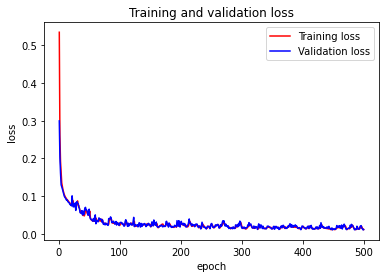

In [14]:
# plot training and validation losses against epochs

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

<ipython-input-15-65af402acde3>:12: RuntimeWarning: invalid value encountered in sqrt
  sqrt = np.sqrt(-2688000 * i**2 + 15772800000)


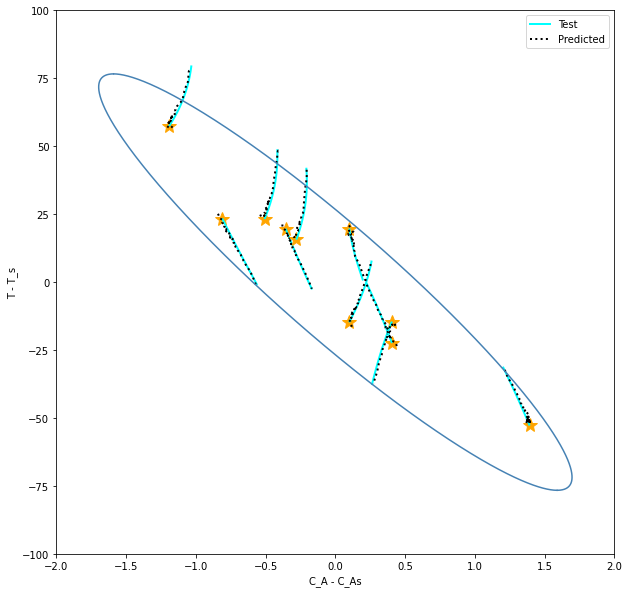

In [15]:
"""
    equation for the stability ellipse is 1060x^2 + 44xy + 0.52y^2 - 372 = 0
"""
# prepare x and y coordinates for plotting the stability region
y = np.linspace(-100, 100, 100000, endpoint=True)

x_upper = list()
x_lower = list()
y_plot = list()

for i in y:
    sqrt = np.sqrt(-2688000 * i**2 + 15772800000)
    if sqrt >= 0:
        y_plot.append(i)
        x_upper.append((-4400 * i + sqrt) / 212000)
        x_lower.append((-4400 * i - sqrt) / 212000)
        pass
    pass


plt.figure(figsize=(10,10))

# plot the first 10 samples and their trajectories
y_predict = model.predict(X_test)
y_predict = scaler_y.inverse_transform(y_predict)
X_plot = scaler_X.inverse_transform(X_test)

for i in range(10):
    if i == 0:  # only add label to 1 data point
        plt.plot(X_plot[i, 0, -2], X_plot[i, 0, -1], marker="*", markersize=15, color='orange')
        plt.plot(y_test[i, :, 0], y_test[i, :, 1], color='cyan', lw=2, label='Test')
        plt.plot(y_predict[i, :, 0], y_predict[i, :, 1], color='black', lw=2, ls=':', label='Predicted')
    else:
        plt.plot(X_plot[i, 0, -2], X_plot[i, 0, -1], marker="*", markersize=15, color='orange')
        plt.plot(y_test[i, :, 0], y_test[i, :, 1], color='cyan', lw=2)
        plt.plot(y_predict[i, :, 0], y_predict[i, :, 1], color='black', lw=2, ls=':')

    
# plot stability region        
plt.plot(x_lower, y_plot, color='steelblue')
plt.plot(x_upper, y_plot, color='steelblue')
plt.ylim([-100, 100])
plt.xlim([-2, 2])

plt.xlabel("C_A - C_As")
plt.ylabel("T - T_s")
plt.legend()
plt.show()       
        